In [2]:
%pylab inline
import os, sys
import emcee
import yaml
import astropy.io.ascii as ascii
from scipy import ndimage
from astropy.io import fits
from astropy.table import Table,join
import astropy as ap
from multiprocessing import Pool,Value
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import warnings
from functools import partial
import corner
from scipy.signal import savgol_filter
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
# from zg_utils import*
from astropy.modeling.functional_models import Sersic2D
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(Om0=0.3,H0=70)
import h5py
from scipy.ndimage import gaussian_filter
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/data/home/zihaoli/my_tools/") 
import zg_utils
from zg_utils import A_lam,corrDust

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0, 0.5, 'ratio')

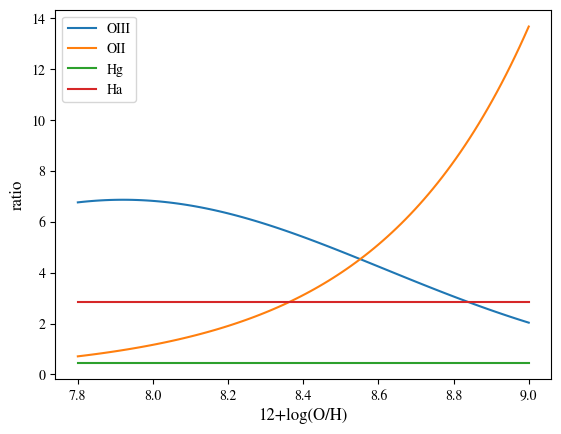

In [3]:
rootpath_caldb     = os.path.expanduser('')
fn_caldb           = 'calibr_sanders23.yml'

caldb = yaml.safe_load(open(os.path.join(rootpath_caldb, fn_caldb), 'r'))
oh12_norm = caldb['norm']
caldb_name = caldb['name'].replace('+','')
a = np.linspace(7.8,9,100)
plt.plot(a,10**np.polyval(caldb['OIII']['bestfit'][::-1],a),label='OIII')
plt.plot(a,10**np.polyval(caldb['OII']['bestfit'][::-1],a),label='OII')
plt.plot(a,10**np.polyval(caldb['Hg']['bestfit'][::-1],a),label='Hg')
plt.plot(a,10**np.polyval(caldb['Ha']['bestfit'][::-1],a),label='Ha')
plt.legend()
plt.xlabel('12+log(O/H)',fontsize=12)
plt.ylabel('ratio',fontsize=12)

In [4]:
def z_mock(z,snr,Av,n=100):
    '''
    z: input metallicity
    snr: SNR of OIII line
    Av: dust attenuation
    n: number of output mock points
    '''
    
    ratio_OIII = 10**np.polyval(caldb['OIII']['bestfit'][::-1],z)*4/3
    ratio_OII = 10**np.polyval(caldb['OII']['bestfit'][::-1],z)
    ratio_Hg = 10**np.polyval(caldb['Hg']['bestfit'][::-1],z)
    ratio_Ha = 10**np.polyval(caldb['Ha']['bestfit'][::-1],z)

    # OIII flux is fixed at 10 and get other lines by line ratio.
    OIII = np.ones(n)*10
    Hb = OIII/ratio_OIII
    OII = Hb*ratio_OII
    Hg = Hb*ratio_Hg
    Ha = Hb*ratio_Ha
    
    # add dust attenuation to each line.
    OIII = corrDust(OIII, 5008.24, Av, output='observed')
    OII = corrDust(OII, 3727.092, Av, output='observed')
    Hg = corrDust(Hg, 4341.692, Av, output='observed')
    Hb = corrDust(Hb, 4862.71, Av, output='observed')
    Ha = corrDust(Ha, 6563, Av, output='observed')

    
    # get the noise sigma based on input OIII SNR, and add the same noise to others lines.
    # Here I assume all the lines have the equal noise level, it seems realistic?
    sig = OIII/snr
    Hg += sig*np.random.randn(n)
    OIII += sig*np.random.randn(n)
    OII += sig*np.random.randn(n)
    Hb += sig*np.random.randn(n)
    Ha += sig*np.random.randn(n)
    
    # set 1 sigma uppr limit
    OIII = np.where(OIII<sig,sig,OIII)
    OII = np.where(OII<sig,sig,OII)
    Hb = np.where(Hb<sig,sig,Hb)
    Hg = np.where(Hg<sig,sig,Hg)
    Ha = np.where(Ha<sig,sig,Ha)

    # output catalog
    out = Table({'id':np.arange(n)})
    out['flux_OIII'] = OIII
    out['flux_OII'] = OII
    out['flux_Hb'] = Hb
    out['flux_Ha'] = Ha
    out['flux_Hg'] = Hg
    out['err_OIII'] = sig
    out['err_Hb'] = sig
    out['err_Ha'] = sig
    out['err_Hg'] = sig
    out['err_OII'] = sig
    out['z_input'] = z
    out['root'] = 'mock'
    return out

In [5]:
from astropy.table import vstack

In [6]:
# input gird of SNR and metallicity
snr_arr = np.arange(2,22,1)
z_arr = np.arange(7.5,8.5,0.05)

In [7]:
len(z_arr),len(snr_arr)

(20, 20)

In [8]:
# All the input data
dic = {}
n = 200
for snr in np.arange(2,22,2):
    snr_key = f'snr_{snr}'
    dic[snr_key] = {}
    for z in np.arange(7.8,8.8,0.2):
        z_key = f'Z_{z:.1f}'
        dic[snr_key][z_key] = z_mock(z,snr,0.1,n)

In [9]:
fn_caldb = '/home/zihaoli/data/JWST/metallicity/calibr_sanders23.yml'

metal_analysis = zg_utils.metal_analysis(fn_caldb=fn_caldb,calib_range='upper')

/data/home/zihaoli/my_tools/zg_utils.py:1128: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.caldb = yaml.load(open(fn_caldb, 'r'))


In [24]:
# Calculate the output.

out_dic = {}
for snr_key in dic:
    out_dic[snr_key] = {}
    for z_key in dic[snr_key]:
        data = dic[snr_key][z_key]
        out_z = metal_analysis.run_from_catalog(data,verbose=False,plot=False,save_path='.',nproc=200,
                                        lines=['OIII','OII','Ha','Hb','Hg'])
        out_dic[snr_key][z_key] = out_z
np.save('z_mock_grid.npy',out_dic)

In [116]:
out_dic = np.load('z_mock_grid.npy',allow_pickle=True).item()

In [127]:
d_z = (z_arr[1] - z_arr[0])/2
d_snr = (snr_arr[1] - snr_arr[0])/2

In [149]:
z_grid = np.zeros(shape=(len(snr_arr),len(z_arr)))

for i,snr in enumerate(snr_arr):
    snr_key = f'snr_{snr}'
    for j,z in enumerate(z_arr):
        z_key = f'Z_{z:.1f}'
        data = out_dic[snr_key][z_key]['me']
        z_med = np.nanmedian(data)
        z_l,z_u = np.nanquantile(data,[0.16,0.84])
        e_l = z_med - z_l
        e_u = z_u - z_med
        dz = z - z_med
        z_grid[i,j] = dz

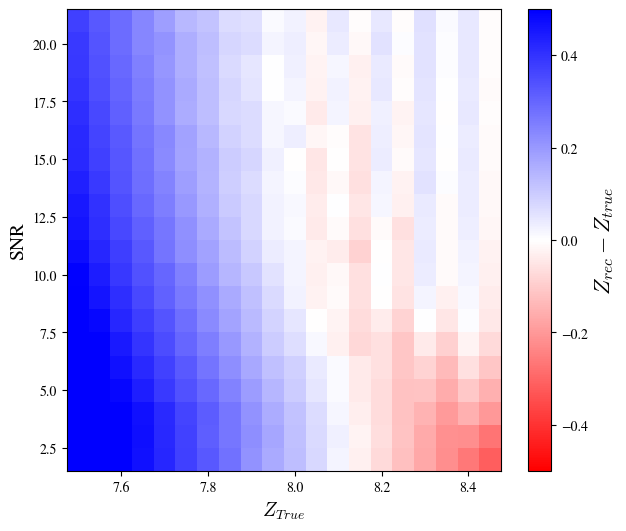

In [151]:
plt.figure(figsize=(7,6))
plt.imshow(-z_grid,extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
           aspect='auto',origin='lower',interpolation='None',cmap='bwr_r',vmin=-0.5,vmax=0.5)
cb = plt.colorbar()
cb.set_label(label=r'$Z_{rec}-Z_{true}$',fontdict={'size':16})
# plt.xticks(z_arr)
# plt.yticks(snr_arr)
plt.xlabel('$Z_{True}$',fontsize=14)
plt.ylabel('SNR',fontsize=14)
plt.show()


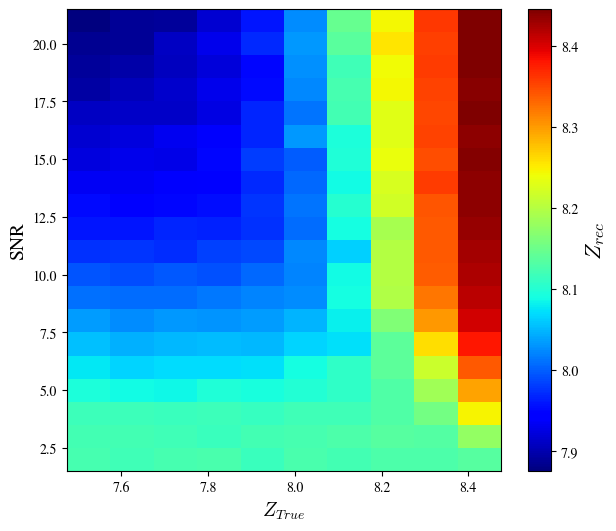

In [163]:
plt.figure(figsize=(7,6))
plt.imshow(-z_grid+np.tile(z_arr,(20,1)),extent=(z_arr[0]-d_z,z_arr[-1]+d_z,snr_arr[0]-d_snr,snr_arr[-1]+d_snr),
           aspect='auto',origin='lower',interpolation='None',cmap='jet')
cb = plt.colorbar()
cb.set_label(label=r'$Z_{rec}$',fontdict={'size':16})
# plt.xticks(z_arr)
# plt.yticks(snr_arr)
plt.xlabel('$Z_{True}$',fontsize=14)
plt.ylabel('SNR',fontsize=14)
plt.show()
